<a href="https://colab.research.google.com/github/XinyaoWa/hydroai-colab/blob/main/Use_SDA_to_run_TwitterRecSys2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below will be deleted when hydro.ai can be installed with pip

In [ ]:
## to be deleted
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/integration/frameworks.bigdata.bluewhale-main')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Environment Preparation**

**Install hydro.ai**

In [ ]:
# pip install hydroailib
# import hydroailib
# import hydroailib.hydroai as hydroai
# import hydroailib.SDA as SDA
# import hydroailib.dataloader as dataloader
# hydroailib_path = hydroailib.__path__[0]
hydroailib_path = './'
hydroailib_path

'./'

**Install sigopt**

Set up sigopt API token

In [ ]:
! pip install sigopt==7.5.0
%env SIGOPT_API_TOKEN=SHJAKPKQIQOESRBQDHLAGYVEZVULHJVJTNAVVQUHFRHLXZVZ

env: SIGOPT_API_TOKEN=SHJAKPKQIQOESRBQDHLAGYVEZVULHJVJTNAVVQUHFRHLXZVZ


**Import SDA and relative libs**

In [ ]:
import os
import pathlib
import yaml
from dataloader.hydrodataloader import *
from hydroai.hydroconfig import *
from hydroai.hydromodel import *
from SDA.modeladvisor.TwitterRecSysAdvisor import *

## **Use SDA to run TwitterRecSys2021 example**

### **Prepare TwitterRecSys2021 dataset**

In [ ]:
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14Lkvye3Wat3bjZelGuQJ4y_vXbHBUAFF' -O TwitterRecSys2021Dataset_sampledata.zip
! unzip TwitterRecSys2021Dataset_sampledata.zip

--2022-01-28 12:30:02--  https://docs.google.com/uc?export=download&id=14Lkvye3Wat3bjZelGuQJ4y_vXbHBUAFF
Resolving docs.google.com (docs.google.com)... 74.125.141.101, 74.125.141.138, 74.125.141.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.141.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-1s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nk1ulpeh3fadmuml677r1qcchrrv1g46/1643373000000/18016102022855825607/*/14Lkvye3Wat3bjZelGuQJ4y_vXbHBUAFF?e=download [following]
--2022-01-28 12:30:04--  https://doc-14-1s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nk1ulpeh3fadmuml677r1qcchrrv1g46/1643373000000/18016102022855825607/*/14Lkvye3Wat3bjZelGuQJ4y_vXbHBUAFF?e=download
Resolving doc-14-1s-docs.googleusercontent.com (doc-14-1s-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to doc-14-1s-docs.googleusercontent.com (doc-14-1s-

### **Parameter setting**

"data_path": can change to you own data set path

"observation_budget": set sigopt experiment budget

"enable_sigopt": disable this if you just want to train with default parameters

"train_script": change the path if you have a customized script

In [ ]:
parameters = {
    'model_name' : 'twitter_recsys',
    'data_path' : './TwitterRecSys2021Dataset_sample',
    'save_path': './result',
    'observation_budget': 5,
    'stage' : 'stage1',
    'target' : 'like',
    'enable_sigopt' : True,
    'enable_model_cache' : False,
    'train_python': 'python',
    'train_script': hydroailib_path+'/modelzoo/TwitterRecSys/TwitterRecSys2021-intel-opt/model_hydroai/xgboost/train.py',  
}

### **Run SDA experiments**

**Define SDA class**

keep this unchanged

In [ ]:
class SDA:
    def __init__(self, model, data_loader, settings, hydro_model=None):
        self.model = model
        self.data_loader = data_loader
        self.dataset_meta = self.data_loader.get_meta()
        self.dataset_train = self.data_loader.get_train()
        self.dataset_valid = self.data_loader.get_valid()
        self.settings = settings
        self.hydro_model = hydro_model
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger('HYDRO.AI.SDA')

    def __create_model_advisor(self):
        if self.model.lower() == 'twitter_recsys':
            return TwitterRecSysAdvisor(self.dataset_meta, self.dataset_train,
                               self.dataset_valid, self.settings)
  
    def launch(self):
        # 1. get model advisor
        # sigopt yaml will be created and sigopt connection will be setup
        self.model_advisor = self.__create_model_advisor()
        self.logger.info("Model Advisor created")

        # 2. initialize_sigopt
        if self.settings["enable_sigopt"]:
            self.logger.info("Start to init sigopt")
            experiment_id = self.hydro_model.sigopt_experiment_id if self.hydro_model else None
            experiment_id = self.model_advisor.initialize_sigopt(
                experiment_id=experiment_id)
            if self.hydro_model:
                self.hydro_model.update(
                    {'sigopt_experiment_id': experiment_id})
                self.model_advisor.record_assignmet(
                    self.hydro_model.model_parameters, self.hydro_model.model)
        else:
            best_model_parameters = self.hydro_model.model_parameters if self.hydro_model else None
            self.model_advisor.initialize_model_parameter(
                assignments=best_model_parameters)
        self.logger.info("model parameter initialized")

        # 3. launch train, w/wo sigopt to iterate train multiple times until we
        # reached numIter or target score
        self.logger.info("start to launch training")
        model_path, metrics, parameters = self.model_advisor.launch_train()
        if self.hydro_model:
            self.hydro_model.update({
                'model': model_path,
                'metrics': metrics,
                'model_parameters': parameters
            })
        self.logger.info("training script completed")
        return model_path, metrics

**define the setting with parameters**

In [ ]:
settings = init_settings()
settings.update(parameters)

**define the data loader**

In [ ]:
data_loader = HydroDataLoaderAdvisor.create_data_loader(settings['data_path'], settings['model_name'])

**Initialize hydro model**
load existing model if enable_model_cache is set True, else initialize with default setting

In [ ]:
if settings["enable_model_cache"] and os.path.exists(f"latest_hydro_model"):
    with open(f"latest_hydro_model", 'r') as f:
        jdata = f.read()
    hydro_model = HydroModel(None, serialized_text=[jdata])
    if hydro_model.model_params['model_name'] == settings['model_name']:
        hydro_model.explain()
    else:
        print("Detected history hydro model, but skip since model type is not the same")
        hydro_model = HydroModel(settings)
else:
    hydro_model = HydroModel(settings)

**Launch SDA experiment**

In [ ]:
sda = SDA(settings['model_name'], data_loader, settings, hydro_model)
sda.launch()

2022-01-28 12:30:39,270 - HYDRO.AI.SDA - INFO - Model Advisor created
2022-01-28 12:30:39,273 - HYDRO.AI.SDA - INFO - Start to init sigopt


experiment: RecSys
metrics:
- name: AP
  objective: maximize
  strategy: optimize
- name: RCE
  objective: maximize
observation_budget: 5
parameters:
- bounds:
    max: 20
    min: 5
  name: max_depth
  type: int
- bounds:
    max: 1.0
    min: 0.0
  name: learning_rate
  type: double
- bounds:
    max: 1
    min: 0.5
  name: subsample
  type: double
- bounds:
    max: 1.0
    min: 0.5
  name: colsample_bytree
  type: double
- bounds:
    max: 1000
    min: 100
  name: num_boost_round
  type: int
project: hydro.ai
Please confirm with sigopt parameters?(n for exit)y


2022-01-28 12:31:01,799 - HYDRO.AI.SDA - INFO - model parameter initialized
2022-01-28 12:31:01,801 - HYDRO.AI.SDA - INFO - start to launch training
2022-01-28 12:31:01,804 - sigopt - INFO - Experiment budget: 5
2022-01-28 12:31:02,368 - sigopt - INFO - training launch command: python -u .//modelzoo/TwitterRecSys/TwitterRecSys2021-intel-opt/model_hydroai/xgboost/train.py --stage stage1 --target like --train_data_path ./TwitterRecSys2021Dataset_sample/train/train.parquet --valid_data_path ./TwitterRecSys2021Dataset_sample/valid/valid.parquet --model_save_path ./result/a044a2bbf1156593d2f2d5f83812138f --max_depth 18 --learning_rate 0.8817390886389768 --subsample 0.5355803786103582 --colsample_bytree 0.7859300426422364 --num_boost_round 494 
2022-01-28 12:31:06,623 - sigopt - INFO - Received sigopt suggestion, assignment is                     OrderedDict([('colsample_bytree', 0.7859300426422364), ('learning_rate', 0.8817390886389768), ('max_depth', 18), ('num_boost_round', 494), ('subsam

('./result/2091c0a1a39845d9aba4959c75749b19',
 [{'name': 'AP', 'value': 0.6249642800760695},
  {'name': 'RCE', 'value': 1.6800228503549453}])

**Save model and explain**

In [ ]:
with open(f"latest_hydro_model", 'w') as f:
    f.write(hydro_model.to_json())
hydro_model.explain()


***    Best Trained Model    ***
  Model Type: twitter_recsys
  Model Saved Path: ./result/2091c0a1a39845d9aba4959c75749b19
  Sigopt Experiment id is 479510
  === Result Metrics ===
    AP: 0.6249642800760695
    RCE: 1.6800228503549453


### **Democratized models performance**

**Twitter RecSys**

For Twitter RecSys 2021 workload, compared with NVIDIA 1st solution, Intel democratized model can significantly reduce training time (>215h vs 9.8h), 21.9x faster than GPU. For inference time, the democratized solutions can reduce the GPU/CPU gap from 92x to 2x while keep less than 5% performmance gap.

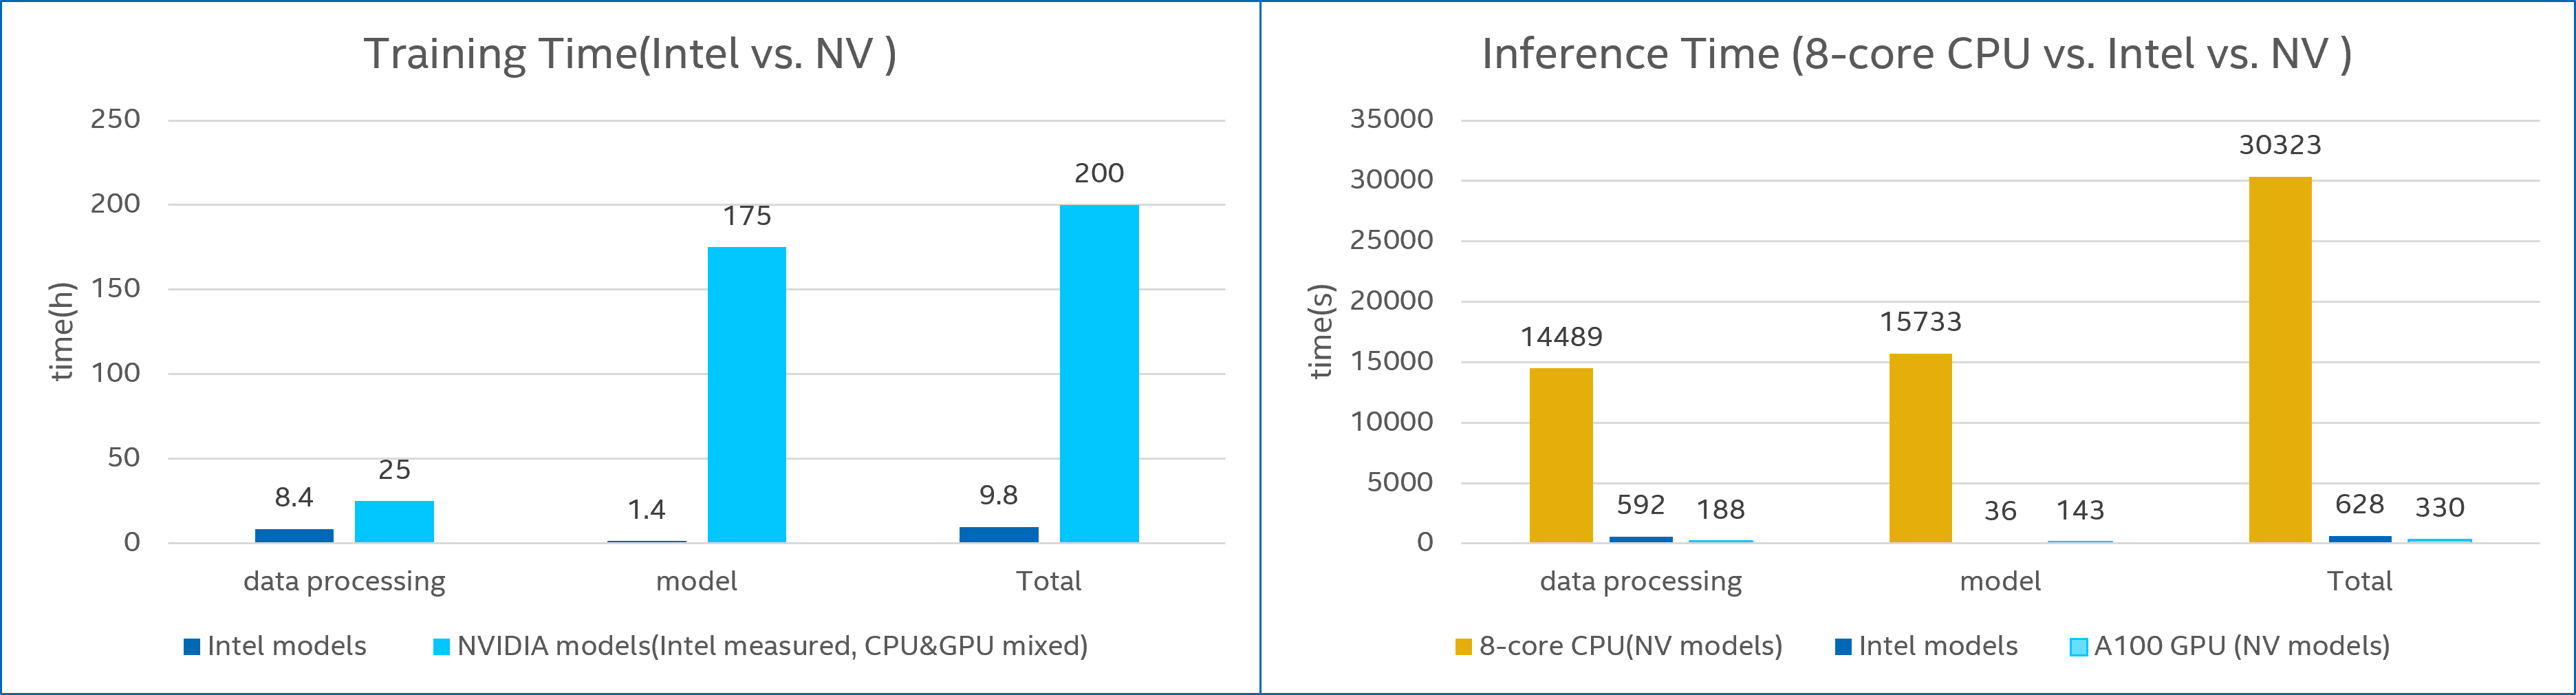